[I 2024-10-17 11:10:22,120] A new study created in memory with name: no-name-1dee8b5f-caef-4e04-8358-286d5ae668c2


7/7 [==============================] - 0s 2ms/step


[I 2024-10-17 11:10:26,703] Trial 0 finished with value: 3.1407941612610006 and parameters: {'unidades_lstm': 71}. Best is trial 0 with value: 3.1407941612610006.


7/7 [==============================] - 0s 2ms/step


[I 2024-10-17 11:10:29,844] Trial 1 finished with value: 7.120966251405405 and parameters: {'unidades_lstm': 19}. Best is trial 0 with value: 3.1407941612610006.


7/7 [==============================] - 0s 2ms/step


[I 2024-10-17 11:10:33,031] Trial 2 finished with value: 9.214017234500313 and parameters: {'unidades_lstm': 16}. Best is trial 0 with value: 3.1407941612610006.


7/7 [==============================] - 0s 2ms/step


[I 2024-10-17 11:10:36,145] Trial 3 finished with value: 5.589692899593733 and parameters: {'unidades_lstm': 32}. Best is trial 0 with value: 3.1407941612610006.


7/7 [==============================] - 0s 2ms/step


[I 2024-10-17 11:10:39,391] Trial 4 finished with value: 2.8378235402592633 and parameters: {'unidades_lstm': 87}. Best is trial 4 with value: 2.8378235402592633.


7/7 [==============================] - 0s 2ms/step


[I 2024-10-17 11:10:42,608] Trial 5 finished with value: 2.975834007440727 and parameters: {'unidades_lstm': 78}. Best is trial 4 with value: 2.8378235402592633.


7/7 [==============================] - 0s 1ms/step


[I 2024-10-17 11:10:45,933] Trial 6 finished with value: 3.2143678229434256 and parameters: {'unidades_lstm': 72}. Best is trial 4 with value: 2.8378235402592633.


7/7 [==============================] - 0s 2ms/step


[I 2024-10-17 11:10:48,943] Trial 7 finished with value: 4.711982022282264 and parameters: {'unidades_lstm': 33}. Best is trial 4 with value: 2.8378235402592633.


7/7 [==============================] - 0s 2ms/step


[I 2024-10-17 11:10:52,082] Trial 8 finished with value: 5.174026886479923 and parameters: {'unidades_lstm': 27}. Best is trial 4 with value: 2.8378235402592633.


7/7 [==============================] - 0s 2ms/step


[I 2024-10-17 11:10:55,736] Trial 9 finished with value: 2.738995266137887 and parameters: {'unidades_lstm': 98}. Best is trial 9 with value: 2.738995266137887.


Mejor número de unidades LSTM: 98
Epoch 1/30
28/28 [==============================] - 2s 21ms/step - loss: 549.2712 - mae: 22.8096 - val_loss: 478.4249 - val_mae: 21.1410
Epoch 2/30
28/28 [==============================] - 0s 7ms/step - loss: 499.1729 - mae: 21.8099 - val_loss: 411.1002 - val_mae: 19.7317
Epoch 3/30
28/28 [==============================] - 0s 7ms/step - loss: 373.9474 - mae: 18.9718 - val_loss: 264.5406 - val_mae: 15.8470
Epoch 4/30
28/28 [==============================] - 0s 7ms/step - loss: 181.0192 - mae: 12.6919 - val_loss: 114.9519 - val_mae: 9.5656
Epoch 5/30
28/28 [==============================] - 0s 8ms/step - loss: 69.1966 - mae: 7.1640 - val_loss: 40.0888 - val_mae: 5.3894
Epoch 6/30
28/28 [==============================] - 0s 7ms/step - loss: 26.1035 - mae: 4.3055 - val_loss: 26.3443 - val_mae: 4.0410
Epoch 7/30
28/28 [==============================] - 0s 6ms/step - loss: 17.1792 - mae: 3.2929 - val_loss: 20.8718 - val_mae: 3.5327
Epoch 8/30
28/28 [========

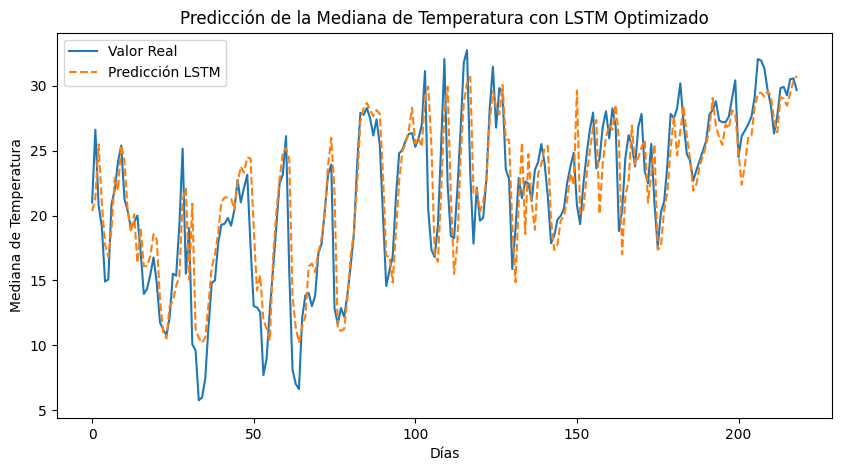

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

SEED = 1234
tf.random.set_seed(SEED)

# 1. Cargar y preparar los datos
datos = pd.read_csv("data\Temp_Asu20092021.csv")

# Convertir 'Fecha' a tipo datetime y establecerla como índice
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos.set_index('Fecha', inplace=True)

# Filtrar datos desde 2019
datos = datos[datos.index.year >= 2019]

# Eliminar valores faltantes
datos.dropna(inplace=True)

# Calcular percentiles diarios (95, 50, 5)

percentiles_diarios = datos.resample('D')['Temperatura'].agg(
    Percentil_95=lambda x: np.percentile(x, 95),
    Mediana=lambda x: np.percentile(x, 50),
    Percentil_5=lambda x: np.percentile(x, 5)
)


# Crear las variables objetivo para el día siguiente
percentiles_diarios['Percentil_95_siguiente'] = percentiles_diarios['Percentil_95'].shift(-1)
percentiles_diarios['Mediana_siguiente'] = percentiles_diarios['Mediana'].shift(-1)
percentiles_diarios['Percentil_5_siguiente'] = percentiles_diarios['Percentil_5'].shift(-1)

# Eliminar filas con valores faltantes después del desplazamiento
percentiles_diarios.dropna(inplace=True)

X = percentiles_diarios[['Percentil_95', 'Mediana', 'Percentil_5']].values
y = percentiles_diarios['Mediana_siguiente'].values

scaler_X = StandardScaler()
X_escalado = scaler_X.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_escalado, y, test_size=0.2, random_state=SEED, shuffle=False
)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 2. Definir función objetivo para Optuna
def objetivo(trial):
    unidades_lstm = trial.suggest_int('unidades_lstm', 10, 100)

    modelo = tf.keras.Sequential([
        tf.keras.layers.LSTM(unidades_lstm, input_shape=(1, X_train.shape[2])),
        tf.keras.layers.Dense(unidades_lstm),
        tf.keras.layers.Dense(1)  # Salida para predecir un valor (mediana del siguiente día)
    ])

    modelo.compile(optimizer='adam', loss='mse', metrics=['mae'])

    modelo.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, shuffle=False)
    
    predicciones = modelo.predict(X_test)
    mae = mean_absolute_error(y_test, predicciones)
    return mae

# 3. Optimización con Optuna
estudio = optuna.create_study(direction='minimize')
estudio.optimize(objetivo, n_trials=10)

# 4. Imprimir los mejores hiperparámetros
mejores_unidades = estudio.best_params['unidades_lstm']
print(f'Mejor número de unidades LSTM: {mejores_unidades}')

# 5. Entrenar el modelo final con los mejores hiperparámetros
modelo_final = tf.keras.Sequential([
    tf.keras.layers.LSTM(mejores_unidades, input_shape=(1, X_train.shape[2])),
    tf.keras.layers.Dense(mejores_unidades),
    tf.keras.layers.Dense(1)
])

modelo_final.compile(optimizer='adam', loss='mse', metrics=['mae'])

historial = modelo_final.fit(
    X_train, y_train, epochs=30, batch_size=32, 
    validation_data=(X_test, y_test), verbose=1, shuffle=False
)

# 6. Evaluar el modelo final
mse, mae = modelo_final.evaluate(X_test, y_test, verbose=0)
print(f'MAE en validación: {mae:.2f}')

# 7. Predicciones y gráfica
predicciones_finales = modelo_final.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Valor Real')
plt.plot(predicciones_finales, label='Predicción LSTM', linestyle='--')
plt.xlabel('Días')
plt.ylabel('Mediana de Temperatura')
plt.title('Predicción de la Mediana de Temperatura con LSTM Optimizado')
plt.legend()
plt.show()